## Overview of Project

## Dataset Calculations/Output

Before addressing any of the research questions, the first task via the reseachers was to normalize to the total protein spectra in each sample. 

There are two trials in this dataset (November 2022, and January 2023) with two biological sample categories (SPP and NAT).

The data is grouped by biological sample category and then the sum is found for the protein percentage of total spectra for each group.

Finally, the normalized protein percentage for each row in the data, based on the biological sample category grouping, is calculated and assigned to a new column in the data. 


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_excel('Malaria_Research_Data.xlsx', header=0)
total_spectra = data.groupby('Biological sample category')['Protein percentage of total spectra'].sum()

# Normalize the protein percentages within each group
data['Normalized protein percentage'] = data.groupby('Biological sample category')['Protein percentage of total spectra'].transform(lambda x: (x / x.sum()) * 100)

data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19264 entries, 0 to 19263
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Experiment name                       19264 non-null  object 
 1   Biological sample category            19264 non-null  object 
 2   Protein group                         19264 non-null  object 
 3   Protein accession number              19264 non-null  object 
 4   Protein name                          19264 non-null  object 
 5   Protein identification probability    19264 non-null  float64
 6   Protein percentage of total spectra   19264 non-null  float64
 7   Number of unique peptides             19264 non-null  int64  
 8   Number of unique spectra              19264 non-null  int64  
 9   Number of total spectra               19264 non-null  int64  
 10  Peptide sequence                      19264 non-null  object 
 11  Previous amino 

## Normalized protein percentages for SPP and NAT

The shape of the data is illustrated via a category scatter plot, so that we can visually see the difference in the two groups of proteins. 

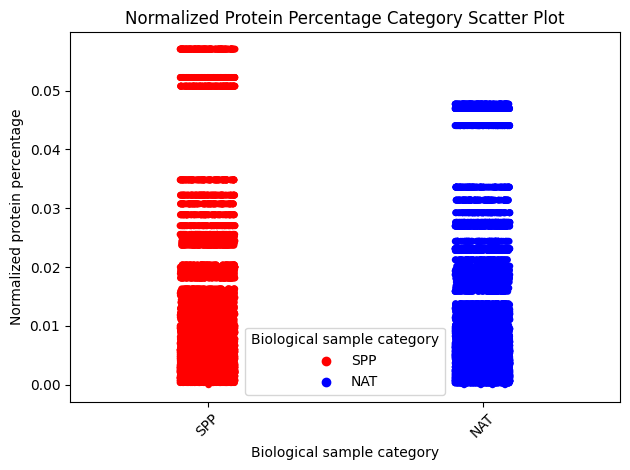

In [2]:
custom_colors = {'SPP': 'red', 'NAT': 'blue'}
sns.stripplot(data=data, x='Biological sample category', y='Normalized protein percentage', hue='Biological sample category', palette=custom_colors, jitter=True)
plt.title('Normalized Protein Percentage Category Scatter Plot')
plt.xlabel('Biological sample category')
plt.ylabel('Normalized protein percentage')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Question 1: What proteins are enriched in SPP vs. NAT?

Which proteins are taken care of mostly by the specific enzyme SPP? 

## Statistical Tests

Using SciPy, which builds upon the "NumPy" library, to provide the statistical functions and distributions for the statistical computations, a few different tests can be run on the data. The ultimate goal is to test the null and alternative hypothesis: is there no difference between the two datasets, or is there a difference? 

The tests include: 

1) Running the Anderson-Darling test to assess the distribution of the data, specifically to evaluate the normality of the data distribution.
2) Performing the Mann-Whitney U test to assess whether there is a significant difference between the distributions of the two groups and test the null and alternative hypothesises. 
3) Finally, for Fischer's exact test, a test requested by the researchers, a table is constructed to summarize the observed frequencies of the two categorical variables, with rows for one protein group, and columns for the other protein group. Again, a test is run to evaluate the null and alternative hypothesises. 



The results of these tests: 

1) The Anderson-Darling test statistic output of 759.289 and 701.77 for each protein is larger than all the critical values, and confirms that the data does not have a normal distribution.
  Even without the visual above, it is important to statistically evaluate the distribution on the data. 
2) Due to the result of the Anderson-Darling test, the Mann-Whitney U test is a better way to test the data because it can still evaluate data that is not normally distributed. After running this test, the significance of the p-value can be measured and the p-value proves to be significant.
3) Finally, for the Fischer's exact test, the significance of the p-value can be measured and it proves to be significant. 

Since there are so many ways to test the data, it is important to find meaningful tests and the Fischer's exact test is the most meaningful test for evaluating this dataset. 

The Anderson-Darling test is for large datasets with more than 50 observations and is sensitive to datasets that have a tail distribution, which is visually illustrated above. 

The Mann-Whitney U test is used when the data distribution is not normal. 

The Fischer's exact test is specific to medical research where sample sizes tend to be small and has a special efficiency in evaluating association between categorical variables, which we are specfically looking at in this dataset. 


In [4]:
import scipy.stats as stats

# Filter proteins for SPP and NAT
spp_proteins = data[data['Biological sample category'] == 'SPP']
nat_proteins = data[data['Biological sample category'] == 'NAT']

# Check normality assumption using Anderson-Darling test
anderson_spp = stats.anderson(spp_proteins['Normalized protein percentage'])
anderson_nat = stats.anderson(nat_proteins['Normalized protein percentage'])

# Perform Anderson-Darling test and provide the results
print(f"Anderson-Darling test results:")
print(f"SPP - statistic: {anderson_spp.statistic}, critical values: {anderson_spp.critical_values}, p-values: {anderson_spp.significance_level}")
print(f"NAT - statistic: {anderson_nat.statistic}, critical values: {anderson_nat.critical_values}, p-values: {anderson_nat.significance_level}")

# Calculate the mean normalized protein percentage for SPP and NAT
spp_mean_percentage = spp_proteins['Normalized protein percentage'].mean()
nat_mean_percentage = nat_proteins['Normalized protein percentage'].mean()


# Perform the Mann-Whitney U test, compare the two groups and produce the U-statistic and p-value
u_stat, p_value = stats.mannwhitneyu(spp_proteins['Normalized protein percentage'], nat_proteins['Normalized protein percentage'])

num_tests = 1
alpha = 0.05  # Desired significance level

# Check if the p-value is significant
if p_value < alpha / num_tests:
    print("The difference in mean normalized protein percentages is statistically significant.")
else:
    print("The difference in mean normalized protein percentages is not statistically significant.")

# Compare the normalized protein perecentage of each protein with the mean 
#normalized protein perecentage of the NAT group
# This specific DataFrame includes only the proteins that have higher normalized protein percentage than the 
# mean normalized protein percentage of the NAT group
# the protein names with counts less than 28 did not meet the condition of being enriched in the SPP group
enriched_proteins = spp_proteins[spp_proteins['Normalized protein percentage'] > nat_mean_percentage]

# Group the filtered data by protein name and calculate counts
sorted_proteins = enriched_proteins['Protein name'].value_counts().reset_index(name='Count').rename(columns={'index': 'Protein name'})

# Create a contingency table
contingency_table = [[len(enriched_proteins), len(nat_proteins) - len(enriched_proteins)],
                     [len(spp_proteins) - len(enriched_proteins), len(nat_proteins)]]

# Perform Fisher's exact test
oddsratio, p_value = stats.fisher_exact(contingency_table)

# Print the results
print("Fisher's exact test results:")
print(f"Odds ratio: {oddsratio}")
print(f"p-value: {p_value}")

# Check if the p-value is significant
alpha = 0.05  # Desired significance level

if p_value < alpha:
    print("The difference in protein enrichment between SPP and NAT is statistically significant.")
else:
    print("The difference in protein enrichment between SPP and NAT is not statistically significant.")

Anderson-Darling test results:
SPP - statistic: 759.2892569494543, critical values: [0.576 0.656 0.787 0.918 1.092], p-values: [15.  10.   5.   2.5  1. ]
NAT - statistic: 701.7789041742417, critical values: [0.576 0.656 0.787 0.918 1.092], p-values: [15.  10.   5.   2.5  1. ]
The difference in mean normalized protein percentages is statistically significant.
Fisher's exact test results:
Odds ratio: 0.6866216805754101
p-value: 2.6222760852778127e-44
The difference in protein enrichment between SPP and NAT is statistically significant.


## Answer to Question 1: Protein Names and Counts

To answer question 1 the method is to: 

Compare the normalized protein perecentage of each protein with the mean normalized protein perecentage of the NAT group.
 
This specific DataFrame includes only the proteins that have higher normalized protein percentage than the 
mean normalized protein percentage of the NAT group.

The protein names with counts less than 28 did not meet the condition of being enriched in the SPP group.

In [5]:
# Create a list to store the unique GN names
unique_gn_list = []

# Print the count and names of the enriched proteins 
print(f"Number of proteins showing up more in SPP than in NAT: {len(sorted_proteins)}")
print("Protein names and their counts:")
for index, row in sorted_proteins.iterrows():
    protein_name = row['Protein name']
    count = row['Count']
    gn_index = protein_name.find('GN=')
    if gn_index != -1:
        gn_name = protein_name[gn_index+3:].split(' ')[0]
        unique_gn_list.append(gn_name)
        print(f"{gn_name}, Count: {count}")
    else:
        print(f"GN Name: Not found, Count: {count}")

Number of proteins showing up more in SPP than in NAT: 52
Protein names and their counts:
PF3D7_1408600, Count: 200
PF3D7_0719600, Count: 167
PF3D7_0818900, Count: 137
PF3D7_1357000, Count: 120
PF3D7_0929400, Count: 117
PF3D7_1462800, Count: 105
PF3D7_1027300, Count: 94
PF3D7_1338200, Count: 84
PF3D7_1108700, Count: 81
PF3D7_0516200, Count: 78
PF3D7_0917900, Count: 73
PF3D7_0507100, Count: 69
PF3D7_0312800, Count: 68
PF3D7_1342000, Count: 66
PF3D7_0618300, Count: 65
PF3D7_1126200, Count: 64
PF3D7_1105400, Count: 55
PF3D7_1451900, Count: 54
MAL3P7.35, Count: 54
PF3D7_0519400, Count: 54
PF3D7_0708400, Count: 53
PF3D7_1242700, Count: 53
PF3D7_1142500, Count: 52
PF3D7_0813900, Count: 51
PF3D7_0629200, Count: 51
PF3D7_1347500, Count: 49
PF3D7_1445900, Count: 44
PF3D7_1437900, Count: 43
PF3D7_1104400, Count: 43
PF3D7_1323400, Count: 42
PF3D7_1302800, Count: 42
FBPA, Count: 42
PF3D7_0306900, Count: 41
PF3D7_1130100, Count: 41
PF3D7_1010700, Count: 41
PF3D7_1224300, Count: 39
PF3D7_1424100, Co

## Illustration of the Protein Names and Counts

The answer to the first question provides the gene names, so that the third question can be answered.

In this illustration the data is re-framed to show the names and counts of the enriched proteins in SPP. 

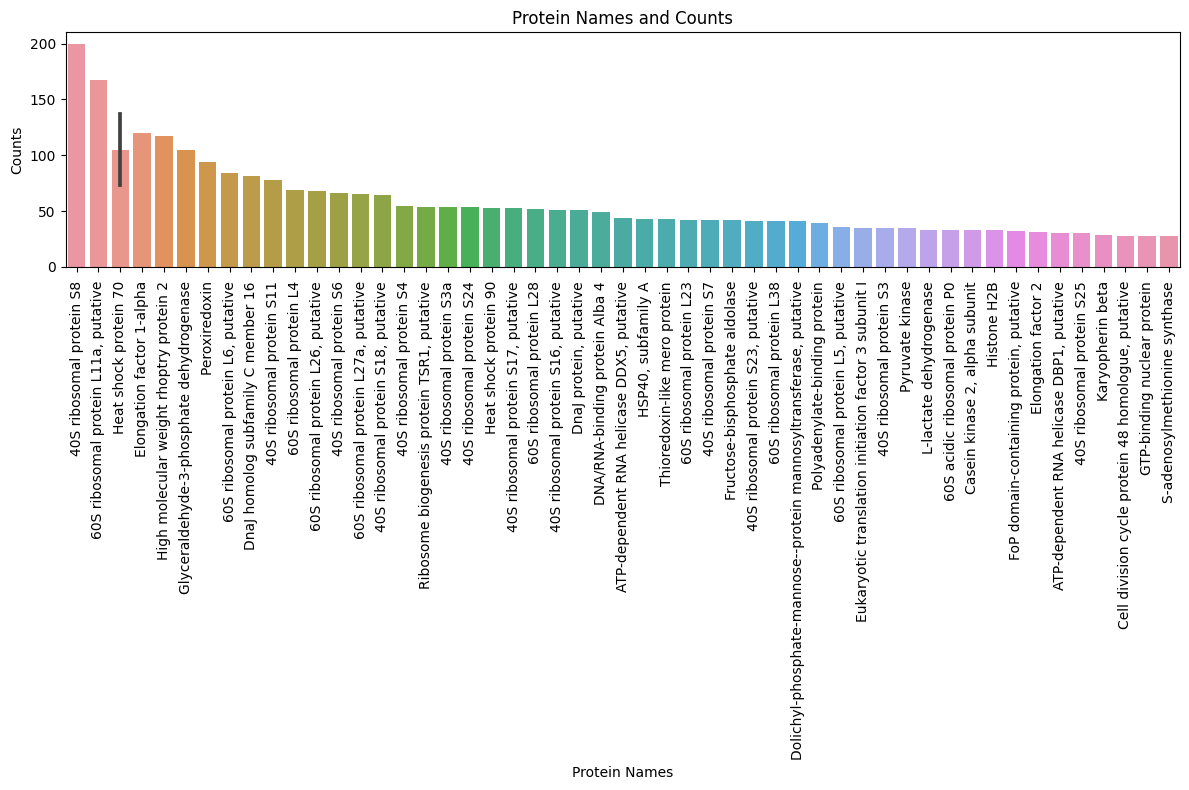

In [5]:
# Create a list to store the unique GN names
unique_protein_list = []

# Store protein names and counts
protein_names = []
counts = []

for index, row in sorted_proteins.iterrows():
    protein_name = row['Protein name']
    count = row['Count']
    os_index = protein_name.find('OS=')
    if os_index != -1:
        protein_name_short = protein_name[:os_index]
        unique_protein_list.append(protein_name_short)
        protein_names.append(protein_name_short)
        counts.append(count)

# Create a bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x=protein_names, y=counts)
plt.xticks(rotation=90)
plt.xlabel('Protein Names')
plt.ylabel('Counts')
plt.title('Protein Names and Counts')


plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import plotly.graph_objects as go
from scipy import stats
import pandas as pd

# Filter proteins for SPP and NAT
spp_proteins = data[data['Biological sample category'] == 'SPP']
nat_proteins = data[data['Biological sample category'] == 'NAT']


# Calculate mean normalized protein percentage for SPP
spp_mean_percentage = spp_proteins['Normalized protein percentage'].mean()

# Calculate mean normalized protein percentage for NAT
nat_mean_percentage = nat_proteins['Normalized protein percentage'].mean()

# Lists to store protein and fold change values
protein_list = []
fold_change_list = []
p_value_list = []
group_list = []

# Iterate through each protein group in SPP
for protein in spp_proteins['Protein group'].unique():
    protein_percentage = spp_proteins.loc[spp_proteins['Protein group'] == protein, 'Normalized protein percentage'].mean()
    fold_change = protein_percentage / nat_mean_percentage
    protein_list.append(protein)
    fold_change_list.append(fold_change)
    group_list.append('SPP')

# Iterate through each protein group in NAT
for protein in nat_proteins['Protein group'].unique():
    protein_percentage = nat_proteins.loc[nat_proteins['Protein group'] == protein, 'Normalized protein percentage'].mean()
    fold_change = protein_percentage / spp_mean_percentage
    protein_list.append(protein)
    fold_change_list.append(fold_change)
    group_list.append('NAT')


 # Print the fold change for each protein
 
print("Fold Change:", fold_change_list)
 

# Select the relevant columns for SPP and NAT protein groups
spp_protein_groups = data[data['Biological sample category'] == 'SPP']['Protein group']
nat_protein_groups = data[data['Biological sample category'] == 'NAT']['Protein group']

# Find the overlapping protein groups in SPP and NAT
overlapping_protein_groups = set(spp_protein_groups) & set(nat_protein_groups)

# Iterate through the overlapping protein groups
for protein_group in overlapping_protein_groups:
    # Create contingency table for the current protein group
    spp_presence = spp_protein_groups == protein_group
    nat_presence = nat_protein_groups == protein_group

    # Count the occurrences of True and False in each group
    spp_counts = np.bincount(spp_presence)
    nat_counts = np.bincount(nat_presence)

    # Create a 2x2 contingency table
    contingency_table = np.array([
        [spp_counts[1], nat_counts[1]],
        [spp_counts[0], nat_counts[0]]
    ])

    # Perform Fisher's exact test for the current protein group
    odds_ratio, p_value = stats.fisher_exact(contingency_table)

    p_value_list.append(p_value)
    group_list.append('SPP')

    significance_values_log = -np.log10(p_value_list)


    # Print the results for the current protein group
    print("Protein group:", protein_group)
    print("Odds Ratio:", odds_ratio)
    print("p-value:", p_value)
  

# Create a scatter plot
fig = go.Figure()

# Iterate through each protein group
for protein, fold_change, p_value in zip(protein_list, fold_change_list, p_value_list):
    # Determine the color based on fold change and significance
    if fold_change >= 2:  
        color = 'blue'  # Significant fold change >= 2
    elif fold_change <= 0.5:  
        color = 'red'  # Significant fold change <= 0.5
    else:
        color = 'gray' 

    # Add a point to the scatter plot
    fig.add_trace(go.Scatter(
        x=[fold_change],  # Convert fold_change to a list
        y=[-np.log10(p_value)],
        text=[protein],
        mode='markers',
        marker=dict(
            color=color,
            size=10
        ),
        hovertemplate='Protein: %{text}<br>Fold Change: %{x}<br>Significance: 10^-%{y:.2f}<extra></extra>',
        name='Protein'
    ))

# Add threshold lines
threshold_up = -np.log10(0.05)  # Adjust the significance threshold as needed
threshold_down = -np.log10(0.05)  # Adjust the significance threshold as needed
fig.add_shape(
    type='line',
    x0=min(fold_change_list),
    x1=max(fold_change_list),
    y0=threshold_up,
    y1=threshold_up,
    line=dict(color='red', width=2, dash='dash')
)
fig.add_shape(
    type='line',
    x0=min(fold_change_list),
    x1=max(fold_change_list),
    y0=threshold_down,
    y1=threshold_down,
    line=dict(color='red', width=2, dash='dash')
)

# Customize the layout
fig.update_layout(
    title='Volcano Plot',
    xaxis_title='log2 Fold Change',
    yaxis_title='-log10(p-value)',
    showlegend=False,
    hoverlabel=dict(
        bgcolor='white',
        font_size=12,
        font_family='Arial'
    ),
    xaxis_range=[-1, 5],  # Adjust the range of the x-axis
    yaxis_range=[min(-np.log10(p_value_list)) - 1, max(-np.log10(p_value_list)) + 1]  # Adjust the range of the y-axis
)

# Display the plot
fig.show()
fig.write_html('volcano_plot.html')





Fold Change: [0.10890789953816252, 0.21781579907632503, 0.072605266358775, 0.072605266358775, 0.12294491770085901, 0.10890789953816252, 0.14521053271755, 0.21781579907632503, 2.027566126539108, 0.10890789953816252, 1.3700452416864493, 0.14521053271755, 0.12294491770085901, 0.072605266358775, 0.3720293848223632, 0.0363026331793875, 0.28004888452670357, 0.10890789953816252, 0.21316906202936337, 0.03779104113974239, 0.072605266358775, 0.072605266358775, 0.26677249296395616, 0.2541184322557125, 0.2247859046467674, 0.10890789953816252, 0.3267236986144875, 0.072605266358775, 0.30639422403403055, 0.548895813672339, 0.14521053271755, 0.38460046808333953, 0.10890789953816252, 0.14521053271755, 0.21781579907632503, 0.10890789953816252, 0.8018701629430042, 0.14521053271755, 0.23316662682075173, 0.702882113367167, 0.11326421551968903, 0.21781579907632503, 0.18151316589693747, 0.10890789953816252, 2.6461507933500963, 0.072605266358775, 0.5540097498245659, 0.10890789953816252, 0.24588983540171802, 0